# Nonlinear Counterfactual Explanation using the DICED Approach

This code demonstrates the generation of counterfactuals for transforming a non-responder into a responder using **Kernel Density Estimation (KDE)** within a nonlinear embedding space.

## Load and Prepare Data

The DDIM latent space data of shape `(110 × 36, 4, 43, 32)` is embedded into a 3D space using **CEBRA** for downstream analysis. The dataset includes: **30 responders** and **80 non-responders** identified based on the percent change in **HAMD-17** scores.

## Method Overview

In this nonlinear approach to counterfactual explainability for classification:

- We embed the high-dimensional DDIM latents using a **neighbor-preserving method** (CEBRA) that captures local geometry.
- An RBF SVM with tuned hyperparameters is trained in the embedded space.
- For counterfactual direction selection:
  - We apply **KDE** to estimate class-specific density distributions in the embedding space.
  - We identify **local maxima** (modes) of the KDE for each class.
  - Counterfactual directions are defined as vectors connecting these modes across classes.
- These direction vectors are then:
  - Scaled by a constant,
  - Interpolated in the embedded space,
  - And finally projected back to the original DDIM latent space using **weighted k-nearest neighbors**.

This pipeline enables smooth and interpretable transformations between classes within a geometry-aware latent representation.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load DDIM dataset of 30 responders and 80 non-responders 
# E-Field mapped on Center slice and coil angles y varies from 10 to 360 degrees
latent_data110 = np.load('110x36_latents.npy')

labels = np.concatenate((np.ones(30*36, dtype ='int'), np.zeros(80*36, dtype = 'int'))) 
labels_reshaped = labels.reshape(110, 36)

## Select random unseen subjects from DDIM latents to test the model

In [4]:
# Select subjects for unseen (5 resps and 5 non-resps)
import random
np.random.seed(42)
i_resp_unseen = random.sample(range(30), 5)
i_non_resp_unseen = random.sample(range(30,110), 5)

Z_latents = latent_data110

Z_unseen = np.concatenate((Z_latents[i_resp_unseen], Z_latents[i_non_resp_unseen]), axis=0)

# Rest data 110-N_unseen subjects
Z_latent_data = np.delete(Z_latents, i_resp_unseen + i_non_resp_unseen, axis=0)

labels_unseen = np.concatenate((labels_reshaped[i_resp_unseen], labels_reshaped[i_non_resp_unseen]), axis=0)
labels_data = np.delete(labels_reshaped, i_resp_unseen + i_non_resp_unseen, axis=0)

In [7]:
# Shuffle the subjects and set the seed for reproducibility
np.random.seed(42)

n_subj = len(labels_data) # no. of subjects to train
idx = np.random.permutation(n_subj)
shuffled_latent_data = Z_latent_data[idx]
n_a = 36 # number of angles

n = n_subj*n_a

sel_latent = shuffled_latent_data.reshape(n, 4*32*32)
shuffled_labels = labels_data[idx].reshape(n)
Z_data = sel_latent


# Shuffle the unseen subjects
n_subj_unseen = len(labels_unseen)
idx_unseen = np.random.permutation(n_subj_unseen)

n_ = n_subj_unseen*n_a

shuffled_Z_unseen = Z_unseen[idx_unseen].reshape(n_, 4*32*32)
shuffled_labels_unseen = labels_unseen[idx_unseen].reshape(n_)

## Upsample the data before CEBRA embedding using SMOTE

In [8]:
# SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for the minority class.
from imblearn.over_sampling import SMOTE
smote = SMOTE()
Z_resampled, y_resampled = smote.fit_resample(Z_data, shuffled_labels)
print(Z_resampled.shape) 

(5400, 4096)


## Embed the remaining upsampled subjects into CEBRA space

In [9]:
#import sklearn.linear_model
#from cebra import CEBRA
#import torch
## Device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)
#
#max_iterations = 5000
#
#cebra_model = CEBRA(model_architecture='offset10-model-mse',
#                        batch_size=512,
#                        learning_rate=1e-6,
#                        output_dimension=3,
#                        delta=0.01,
#                        temperature=1,
#                        max_iterations=max_iterations,
#                        distance='euclidean',
#                        conditional='delta',   #time
#                        device='cuda_if_available',
#                        verbose=True,#  
#                        time_offsets=10)
#
#shuffled_Z_data_cebra = cebra_model.fit_transform(Z_resampled)

## Transform the unseen sujects into trained CEBRA space
#Z_cebra_unseen = cebra_model.transform(shuffled_Z_unseen)
#print(Z_cebra_unseen.shape)
#np.save('shuffled_Z_data_cebra.npy',shuffled_Z_data_cebra)
#np.save('Z_cebra_unseen.npy',Z_cebra_unseen)

shuffled_Z_data_cebra = np.load('shuffled_Z_data_cebra.npy')
Z_cebra_unseen = np.load('Z_cebra_unseen.npy')

## SVM Classification
### Import necessary libraries

In [10]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

### Scale the CEBRA data and unseen CEBRA data 

In [12]:
# Scale the data
scaler = StandardScaler()

X = scaler.fit_transform(shuffled_Z_data_cebra)
X_unseen = scaler.transform(Z_cebra_unseen)

y = y_resampled
y_unseen = shuffled_labels_unseen

### Choose the best SVM model by optimizing over different hyperparameters

Best parameters: {'C': 0.01, 'gamma': 0.01}
Best Score: 0.9575925925925926


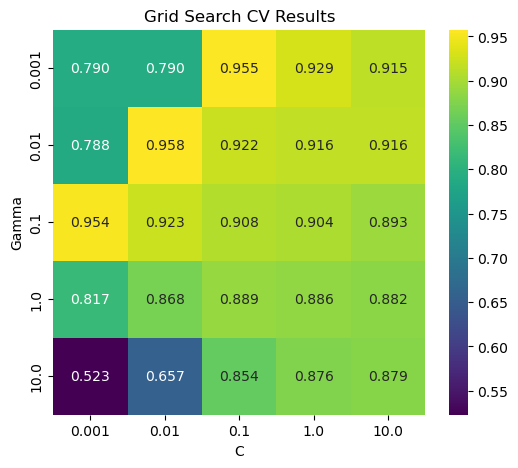

In [13]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

total_non_resps = 80
unseen_non_resps = 5
upsampled_subjects = (total_non_resps - unseen_non_resps)*2 # upsampled subjects in the data

# Define subject indices for cross-validation
subject_ids = np.repeat(np.arange(upsampled_subjects), n_a)  # Assign same ID to all angles of a subject

# Define SVM model with class_weight="balanced"
clf = SVC(kernel='rbf', probability=True, class_weight='balanced')

# Parameter grid for hyperparameter tuning
param_grid = {
    'C': [1e-3, 1e-2, 0.1, 1, 10],
    'gamma': [1e-3, 1e-2, 0.1, 1, 10]
}

# Custom scorer for F1-score optimization
f1_scorer = make_scorer(f1_score)

# Define a custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)  # True Negative Rate
specificity_scorer = make_scorer(specificity_score)

def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)  # True Positive Rate   
sensitivity_scorer = make_scorer(sensitivity_score)

# Use GroupKFold to ensure subjects are in separate folds
group_kfold = GroupKFold(n_splits=5)

# Grid Search with sensitivity scoring as the no. of responders << no. of non-responders
grid_search = GridSearchCV(clf, param_grid, cv=group_kfold, scoring=sensitivity_scorer, n_jobs=-1)
grid_search.fit(X, y, groups = subject_ids)

# Best parameters based on F1-score
print("Best parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Extract results
results = pd.DataFrame(grid_search.cv_results_)

# Group by C and gamma, then compute the mean test score
results_grouped = results.groupby(['param_C', 'param_gamma'])['mean_test_score'].mean().reset_index()

# Pivot table for heatmap
pivot = results_grouped.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title("Grid Search CV Results")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.show()

### Make predictions on unseen subjects data

In [14]:
print('Predictions for unseen data')
#print("SVM best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X, y)

y_pred = best_model.predict(X_unseen)

# Define a custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)  # True Negative Rate
    
# Define a custom scorer for specificity
def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)  # True Positive Rate

# Compute accuracy
accuracy = accuracy_score(y_unseen, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Compute the F1 score
f1 = f1_score(y_unseen, y_pred) 
print(f"F1 Score: {f1:.2f}")

spec = specificity_score(y_unseen, y_pred)
print(f"Specificity: {spec:.2f}")

sens = sensitivity_score(y_unseen, y_pred)
print(f"Sensitivity: {sens:.2f}")
    
y_pred_probs_u = best_model.predict_proba(X_unseen)[:, 1]
auc = roc_auc_score(y_unseen, y_pred_probs_u)
print(f"AUC: {auc:.2f}")

print('Unseen subjects labels:', y_unseen)
print('Predicted labels:', y_pred)

Predictions for unseen data
Accuracy: 0.66
F1 Score: 0.63
Specificity: 0.74
Sensitivity: 0.58
AUC: 0.67
Unseen subjects labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Corr. predicted labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

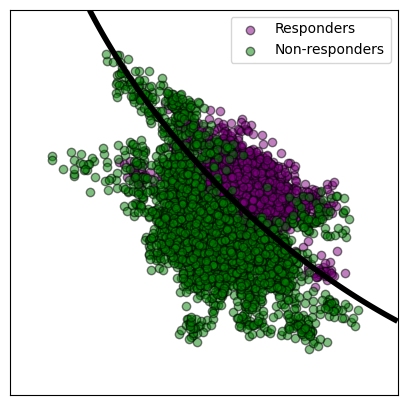

In [15]:
## Visualize the decision boundary from SVM

indx_resp = np.where(y == 1)[0]
indx_n_resp = np.where(y == 0)[0]

X_class0 = X[indx_resp]
X_class1 = X[indx_n_resp]

# Create a meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
X_grid, Y_grid, Z_grid = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1), np.arange(z_min, z_max, 0.1))

# Now stack all 3
grid_points = np.c_[X_grid.ravel(), Y_grid.ravel(), Z_grid.ravel()]

decision_values = best_model.decision_function(grid_points)
decision_values = decision_values.reshape(X_grid.shape)

# Plot decision boundary
z_idx = Z_grid.shape[1]//2

plt.figure(figsize=(5, 5))
plt.scatter(X_class0[:, 0], X_class0[:, 1], color='purple', alpha=0.5, edgecolor='k', label = 'Responders')
plt.scatter(X_class1[:, 0], X_class1[:, 1], color='green', alpha=0.5, edgecolor='k', label = 'Non-responders')
plt.contour(X_grid[:,:,z_idx-10], Y_grid[:,:,z_idx-10], decision_values[:,:,z_idx-12], levels=[0], colors='black', linewidths=4)
#plt.title('Decision Boundary')
#plt.xlabel('X1')
#plt.ylabel('X2')
plt.legend(loc='best')
plt.xticks([])
plt.yticks([])
plt.show()

# Kernel Density Estimation (KDE)
KDE is used to evaluate the probability density in the reduced 3D space. \
Compute KDE for responders and non-responders. \
Identify non-responder peak point and responder peak point.

In [23]:
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

# Compute KDE for each class
#kde_class0 = gaussian_kde(X_class0.T)
#kde_class1 = gaussian_kde(X_class1.T)

# Evaluate KDE on grid
#Z_class0 = np.reshape(kde_class0(grid_points.T), X_grid.shape)
#Z_class1 = np.reshape(kde_class1(grid_points.T), X_grid.shape)

def find_kde_peaks(kde_arr):
    '''
    Takes smoothed 2d array kde_arr. Returns sorted local maxima (decreasing).
    '''
    from skimage.feature import peak_local_max
    # Find local maxima
    coordinates = peak_local_max(kde_arr, min_distance=1)
    sort_idx = np.argsort([kde_arr[c[0],c[1],c[2]] for c in coordinates])[::-1]
    return coordinates[sort_idx]

# Fit KDE models using sklearn (faster than scipy for large N)
kde0 = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde1 = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde0.fit(X_class0)
kde1.fit(X_class1)

grid_positions = np.vstack([
    X_grid.ravel(), 
    Y_grid.ravel(), 
    Z_grid.ravel()
]).T

# Evaluate log density over the grid
log_density0 = kde0.score_samples(grid_positions)
log_density1 = kde1.score_samples(grid_positions)

# Convert to actual density (optional)
Z_class0 = np.reshape(np.exp(log_density0), X_grid.shape)
Z_class1 = np.reshape(np.exp(log_density1), X_grid.shape)

# Detect dominant regions
peaks_1_minus_0 = find_kde_peaks(Z_class1 - Z_class0)
peaks_0_minus_1 = find_kde_peaks(Z_class0 - Z_class1)

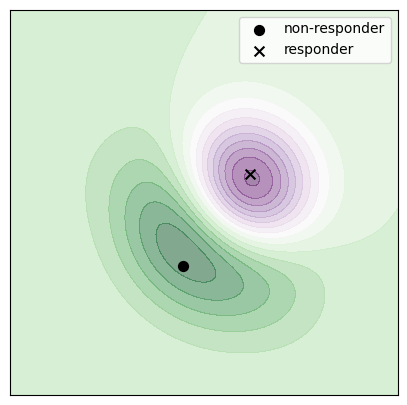

In [28]:
n_responders0 = peaks_1_minus_0[0]
n_responders1 = peaks_1_minus_0[1]

responders0 = peaks_0_minus_1[0]

# Convert peak indices to actual coordinates in physical space
n_responder_coords0 = np.array([
    X_grid[n_responders0[0], n_responders0[1], n_responders0[2]],
    Y_grid[n_responders0[0], n_responders0[1], n_responders0[2]],
    Z_grid[n_responders0[0], n_responders0[1], n_responders0[2]]
])

n_responder_coords1 = np.array([
    X_grid[n_responders1[0], n_responders1[1], n_responders1[2]],
    Y_grid[n_responders1[0], n_responders1[1], n_responders1[2]],
    Z_grid[n_responders1[0], n_responders1[1], n_responders1[2]]
])

responder_coords0 = np.array([
    X_grid[responders0[0], responders0[1], responders0[2]],
    Y_grid[responders0[0], responders0[1], responders0[2]],
    Z_grid[responders0[0], responders0[1], responders0[2]]
])

# Choose a slice index along the z-axis
z_idx = Z_grid.shape[2] // 2

# Slice all arrays to get a 2D grid at fixed z
X_slice = X_grid[:, :, z_idx]
Y_slice = Y_grid[:, :, z_idx]
Z_diff_slice = (Z_class0 - Z_class1)[:, :, z_idx-4]


# Plot the KDE contours with peak points
plt.figure(figsize=(5, 5))

plt.contourf(X_slice, Y_slice, Z_diff_slice, levels=20, cmap='PRGn_r', alpha=0.5, origin='image')
plt.scatter(n_responder_coords0[1], n_responder_coords0[2], color='black', marker='o', s=50, label = 'non-responder')
plt.scatter(responder_coords0[1], responder_coords0[2], color='black', marker='x', s=50, label='responder')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

# Counterfactual Transformation
Apply transformations to shift a non-responder ($\bullet$) towards responders ($\times $).

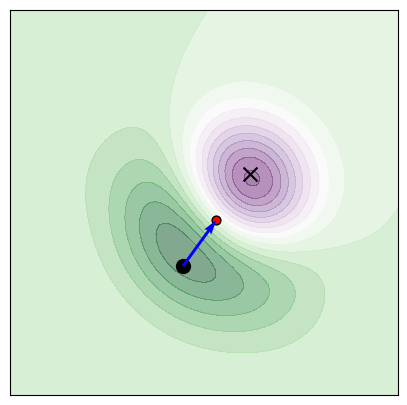

In [29]:
def transform_to_responder(non_responder, responder, alpha=10.0):
    """
    Transforms a non-responder to a responder using the vector direction.
    Args:
        non_responder: Coordinates of the non-responder.
        responder: Coordinates of the responder peak.
        alpha: Scaling factor for the transformation.
    Returns:
        Transformed coordinates.
    """
    vector = responder - non_responder
    return non_responder + alpha * vector

# Example: Transforming a non-responder to a responder

# Apply the transformation
alpha = 0.5  # Scaling factor
transformed_nonresponder1 = transform_to_responder(n_responder_coords0, responder_coords0, alpha)

# Visualize transformation
plt.figure(figsize=(5, 5))

plt.contourf(X_slice, Y_slice, Z_diff_slice, levels=20, cmap='PRGn_r', alpha=0.5, origin='image')

plt.scatter(n_responder_coords0[1], n_responder_coords0[2], color='black', marker='o', s=100)
plt.scatter(responder_coords0[1], responder_coords0[2], color='black', marker='x', s=100)
plt.scatter(transformed_nonresponder1[1], transformed_nonresponder1[2], color='red', edgecolor='k', s=40)
plt.quiver(n_responder_coords0[1], n_responder_coords0[2],
           transformed_nonresponder1[1] - n_responder_coords0[1],
           transformed_nonresponder1[2] - n_responder_coords0[2],
           angles='xy', scale_units='xy', scale=1, color='blue')
#plt.legend()
#plt.title('Transformation of Non-Responder to Responder')
plt.xticks([])
plt.yticks([])
plt.show()


In [30]:
# Transform a non-responder to responder in 5 steps by varying alpha from 0 to 1
steps = 5
alpha_values = np.linspace(0, 1, steps)
tf_nr1_list = []
for alpha in alpha_values:
    transformed_nonresponder1 = transform_to_responder(n_responder_coords0, responder_coords0, alpha)
    tf_nr1_list.append(scaler.inverse_transform(transformed_nonresponder1.reshape(1,3)))

tf_nr1 = np.array(tf_nr1_list)

# Back-Projection to High-Dimensional latent Space
Transformations in 3D CEBRA space are projected back into the original high-dimensional DDIM latent space using nearest neighbors.

In [31]:
from sklearn.neighbors import NearestNeighbors

# Using nearest neighbors to project back to high-dimensional space
def find_high_dim_neighbors(z_1, embedded_space, high_dim_space, k=30):
    nbrs = NearestNeighbors(n_neighbors=k).fit(embedded_space)
    distances, indices = nbrs.kneighbors([z_1])  # Ensure z_1 is 2D for input
    weights = 1 / (distances + 1e-5)  # Small value to avoid division by zero
    weights /= weights.sum()  # Normalize weights
    high_dim_neighbors = high_dim_space[indices[0]]
    weighted_avg = np.average(high_dim_neighbors, axis=0, weights=weights[0])
    return weighted_avg, indices[0]


transf1 = []

for i in range(5):
    Z_tf1, neighbors_resp = find_high_dim_neighbors(tf_nr1[i,0], shuffled_Z_data_cebra, Z_resampled)
    transf1.append(Z_tf1)
    

transformation1 = np.array(transf1)

# Image Generation
Using a pre-trained Latent Diffusion Model (LDM) and DDIM, the high-dimensional latent vectors are decoded into visual images.

In [32]:
# Import libraries
import torch
import torchvision
import numpy as np
import random
import copy
import gc
#import sys
import os
import PIL
from PIL import Image

from models import *

import matplotlib.pyplot as plt
from diffusers import LMSDiscreteScheduler, DDIMScheduler, AutoencoderKL
import timeit
from tqdm.auto import tqdm


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# To the GPU we go!
vae = vae.to(device)

# The noise scheduler
noise_scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

niters = 40000
# Load pretrained model
Filename_LDM = 'CcLDM_checkpoint_niters_{}.pth'.format(niters)
print("Loading pre-trained continuous conditional latent diffusion model >>>")
checkpoint = torch.load(Filename_LDM, map_location=device,weights_only=True)
netLDM = cont_cond_unet_diffusion_model().to(device)
netLDM = nn.DataParallel(netLDM)
#netLDM.load_state_dict(checkpoint['netLDM_state_dict'])    
# Adjust checkpoint keys if necessary
checkpoint_state_dict = checkpoint['netLDM_state_dict']
adjusted_state_dict = {}

for key, value in checkpoint_state_dict.items():
    # Replace naming inconsistencies
    new_key = key.replace("query", "to_q").replace("key", "to_k").replace("value", "to_v").replace("proj_attn", "to_out.0")
    adjusted_state_dict[new_key] = value

# Load the adjusted state dict
netLDM.load_state_dict(adjusted_state_dict, strict=True)

Loading pre-trained continuous conditional latent diffusion model >>>


<All keys matched successfully>

In [33]:
# Sample function (regular DDIM) (invert noisy latents back to original latents)
@torch.no_grad()
def sample(start_step=0, start_latents=None, num_inference_steps=30, labels=y, device=device):
  
    # Set num inference steps
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    latents_list = []
    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 32, 32, device=device)
        start_latents *= noise_scheduler.init_noise_sigma

    latents = start_latents.clone()
    timesteps_sample = noise_scheduler.timesteps.long()
    for i in tqdm(range(start_step, num_inference_steps-1)):
    
        #t = noise_scheduler.timesteps[i]
        t = timesteps_sample[i]

        # predict the noise residual
        noise_pred = netLDM.module(latents, t, labels)

        
        prev_t = t-1#max(1, t.item()-1) #max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = noise_scheduler.alphas_cumprod[t]
        alpha_t_prev = noise_scheduler.alphas_cumprod[prev_t]
        beta_t = 1 - alpha_t
        pred_original_sample = (latents - beta_t ** 0.5 * noise_pred) / alpha_t ** 0.5
        pred_sample_direction = (1 - alpha_t_prev) ** 0.5 * noise_pred
        prev_sample = alpha_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        latents = prev_sample

        # Store
        latents_list.append(latents)
    return latents_list

  0%|          | 0/899 [00:00<?, ?it/s]

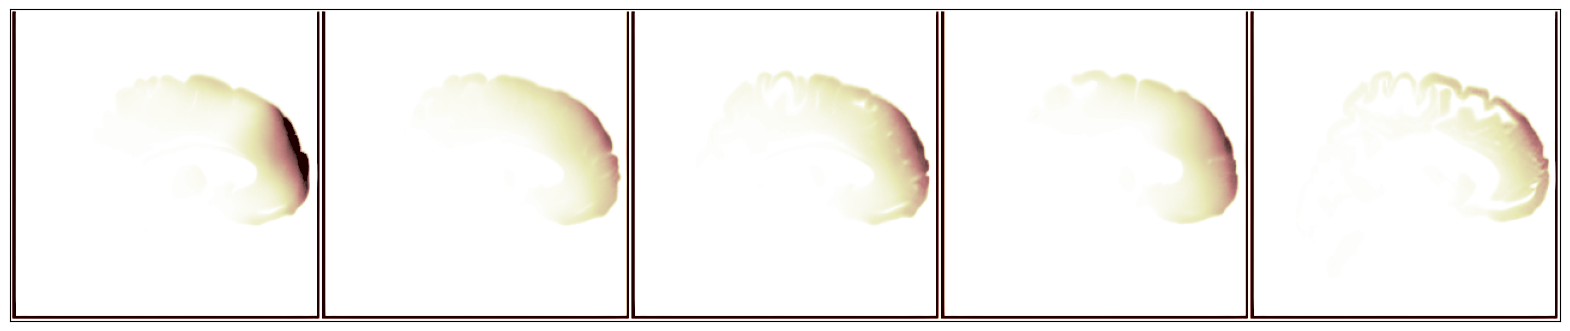

In [38]:
latents_d1 = torch.tensor(transformation1.reshape(5,4,32,32)).type(torch.float).to(device) 

labels_train_90 = np.repeat(0.22857,5).reshape(5,1) # (normalized label) Fix y=90 degree

test_labels = torch.tensor(labels_train_90).type(torch.float).unsqueeze(-1).to(device)

ddim_latents = sample(start_latents=latents_d1, num_inference_steps=900, 
                       labels=test_labels, start_step=0, device=device)

ddim_sample = (1 / 0.18215) * ddim_latents[-1]
with torch.no_grad():
    ddim_sample = vae.decode(ddim_sample).sample 

def cmap_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=5)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8)).convert("L")
    gamma = 0.8
    grid_im_grey = np.array(grid_im)**gamma
    plt.figure(figsize=(20,20))
    fig = plt.imshow(grid_im_grey, cmap="pink_r",vmax=0.7*np.max(grid_im_grey))
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()
    return fig
cmap_images(ddim_sample)     

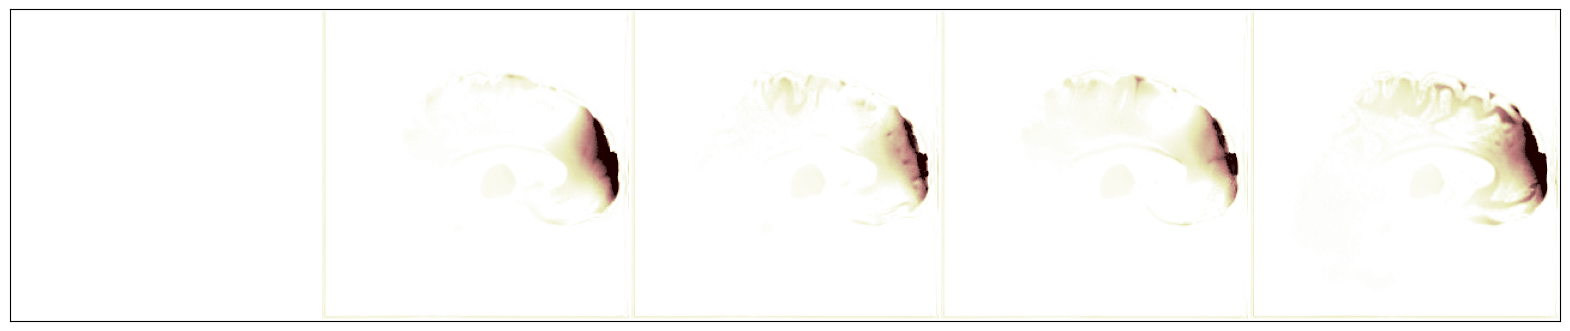

In [41]:
def cmap_res_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    #x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=5)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8)).convert("L")
    gamma = 0.8
    grid_im_grey = np.array(grid_im)**gamma
    plt.figure(figsize=(20,20))
    fig = plt.imshow(grid_im_grey, cmap="pink_r",vmax=0.7*np.max(grid_im_grey))
    plt.xticks([])
    plt.yticks([])
    #plt.colorbar()
    return fig
cmap_res_images(ddim_sample[0]-ddim_sample) 